In [1]:
import numpy as np
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar10
from keras.utils import plot_model
from keras import backend as K
import matplotlib.pyplot as plt
import os

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


# Load the CIFAR10 data.
(x_train, _), (x_test, _) = cifar10.load_data()

# Input image dimensions.
# We assume data format "channels_last".
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

170500096/170498071 [==============================] - 24s 0us/step


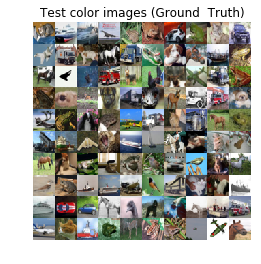

In [3]:
# Display the 1st 100 input images (color and gray)
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

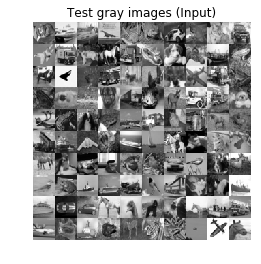

In [4]:
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()


In [5]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

In [6]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

In [7]:
# Network parameters
input_shape = (img_rows, img_cols, 1)
batch_size = 128
kernel_size = 3
filters = 32
latent_dim = 256

# Build the Autoencoder Model
# First build the Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D blocks
for i in range(3):
    filters = filters * 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

In [8]:
# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate a latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [9]:
# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [11]:
# Stack of Transposed Conv2D blocks
for i in range(3):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)
    filters //= 2

x = Conv2DTranspose(filters=channels,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

In [12]:
# Instantiate Decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              1052672   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 64)        73792     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 32, 32, 3)         1731      
__________

In [13]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

In [14]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

callbacks = [lr_reducer, checkpoint]

# Train the autoencoder
autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=10,
                batch_size=batch_size,
                callbacks=callbacks)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 15s 290us/step - loss: 0.0213 - val_loss: 0.0131

Epoch 00001: val_loss improved from inf to 0.01312, saving model to /home/ubuntu/saved_models/colorized_ae_model.001.h5
Epoch 2/10
50000/50000 [==============================] - 7s 131us/step - loss: 0.0115 - val_loss: 0.0105

Epoch 00002: val_loss improved from 0.01312 to 0.01054, saving model to /home/ubuntu/saved_models/colorized_ae_model.002.h5
Epoch 3/10
50000/50000 [==============================] - 7s 131us/step - loss: 0.0099 - val_loss: 0.0098

Epoch 00003: val_loss improved from 0.01054 to 0.00977, saving model to /home/ubuntu/saved_models/colorized_ae_model.003.h5
Epoch 4/10
50000/50000 [==============================] - 7s 131us/step - loss: 0.0091 - val_loss: 0.0088

Epoch 00004: val_loss improved from 0.00977 to 0.00882, saving model to /home/ubuntu/saved_models/colorized_ae_model.004.h5
Epoch 5/10
50000/50000 [=====

In [15]:
# Predict the Autoencoder output from test data
x_decoded = autoencoder.predict(x_test_gray)

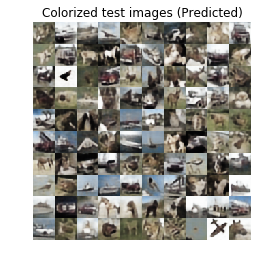

In [16]:
# Display the 1st 100 colorized images
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()